In [117]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import datetime as dt
import plotly.graph_objects as go

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.recognition_evaluators' in sys.modules:
    del sys.modules['pygents.recognition_evaluators']

from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot, plot_bar_from_list, \
    build_triple_list, build_triple_matrix, plot_bar_from_list_minmax
from pygents.util import dictcount, contains_seq, agg_min_max_avg_mpe
from pygents.recognition_evaluators import df2labeled, language_metrics, our_evaluator_test, our_evaluator_tm, our_evaluator_top, \
    our_evaluator_true, our_evaluator_false, our_evaluator_random, pre_rec_f1_from_counts, evaluate_tm_df, evaluate_metrics, evaluate_model, \
    full_test_circle, dictval, our_evaluator_top1

grand_t0 = dt.datetime.now()

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

DS = 'Shreevastava21'

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df = pd.read_csv(multiclass_dataset_file_path) 
df = df.drop('Id_Number', axis=1) # delete columnb with id 

#df = df3[0:5] # hack for test!

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [18]:
test_kaggle_multiclass_path = './temp/test/'
inclusion_thresholds = [0,10,20,30,40,50,60,70,80,90]
detection_thresholds = [10,20,30,40,50,60,70,80,90]
#selection_metrics = ['F','UF','FN','TF-IDF','UFN','UFN/D/D','FN*UFN','FN*UFN/D','NLMI','FCR','CFR','MR']
selection_metrics = ['F','UF','FN','UFN','TF-IDF','FCR','CFR','MR','NLMI']
n_max_values = [1,2,3,4,5]
splits = [0,1,2]


In [3]:
results = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top,accumulator=accumulator)
    results.append(accumulator)
            

Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_state

In [4]:
summary = []
for l1,l2,l3 in zip(results[0],results[1],results[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
F1 = summary[0][6]
print(f'DS={DS}, NM={NM}, IT={IT}, SM={SM}, DT={DT}, F1={F1}')
print()
for s in summary[:20]:
    print(s)

DS=Shreevastava21, NM=2, IT=10, SM=FCR, DT=70, F1=0.40006021497665856

(2, 10, 'FCR', 70, 0.3813662258642483, 0.41287111562462975, 0.40006021497665856, 3.115195898447599)
(2, 20, 'UFN', 60, 0.3635453140882624, 0.3890215822824518, 0.3782958162364718, 2.5994652007092927)
(2, 20, 'FN', 60, 0.37358457559455305, 0.3737886612752467, 0.3736527927166587, 0.02424149928068822)
(1, 10, 'FCR', 50, 0.3040886951213039, 0.41940611625633994, 0.37319425944430673, 12.344878049285875)
(2, 20, 'FCR', 60, 0.35343167372034967, 0.39120793450215396, 0.3680683853747318, 4.191168461600534)
(3, 20, 'FN', 70, 0.3561544044799408, 0.38368590455827667, 0.3665385520250502, 3.1187901770024586)
(2, 10, 'UFN', 70, 0.36044309001524694, 0.3646637433621928, 0.36189164284668834, 0.5106686067131004)
(3, 20, 'UFN', 70, 0.3522603447968328, 0.3666187838590751, 0.3605714014718915, 1.5366455651838635)
(5, 20, 'TF-IDF', 80, 0.30065151368479537, 0.46046217998984396, 0.35711224752847565, 19.293640991338872)
(4, 20, 'TF-IDF', 80, 0.3

In [19]:
results1 = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top1,accumulator=accumulator)
    results1.append(accumulator)


Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_state

In [20]:
summary = []
for l1,l2,l3 in zip(results1[0],results1[1],results1[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4]
F1 = summary[0][6]
print(f'DS={DS}, NM={NM}, IT={IT}, SM={SM}, DT={DT}, F1={F1}')
print()
for s in summary[:20]:
    print(s)

DS=Shreevastava21, NM=2, IT=10, SM=FCR, DT=70, F1=0.4550365307616822

(2, 10, 'FCR', 70, 0.4038565832729025, 0.4911649688364944, 0.4550365307616822, 7.498291386717158)
(1, 10, 'UFN', 50, 0.3543478260869565, 0.5836758823397221, 0.45100200425307885, 19.61172039673001)
(2, 20, 'FCR', 60, 0.4160541592406384, 0.468620992534036, 0.4394825626965278, 4.420111635938985)
(2, 20, 'UFN', 60, 0.40143834879129, 0.4577137488034306, 0.42350134965219355, 5.3856418921819955)
(2, 10, 'FN', 70, 0.339151821177729, 0.47047694736808554, 0.41115634353974606, 11.675124478134416)
(1, 10, 'UFN', 40, 0.35312373927862994, 0.4492518079270723, 0.4103886965259462, 9.302555964151377)
(2, 20, 'FN', 60, 0.3816370146196161, 0.43456908941709005, 0.41008089571120615, 4.624108948432332)
(2, 10, 'UFN', 70, 0.3635855919134404, 0.4358257630880721, 0.4064680896950626, 7.033352083274755)
(1, 10, 'FN', 50, 0.31081600684010324, 0.5455926672043362, 0.4042249692702244, 23.315019882671244)
(3, 20, 'FN', 70, 0.3612296231090576, 0.4373

Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})


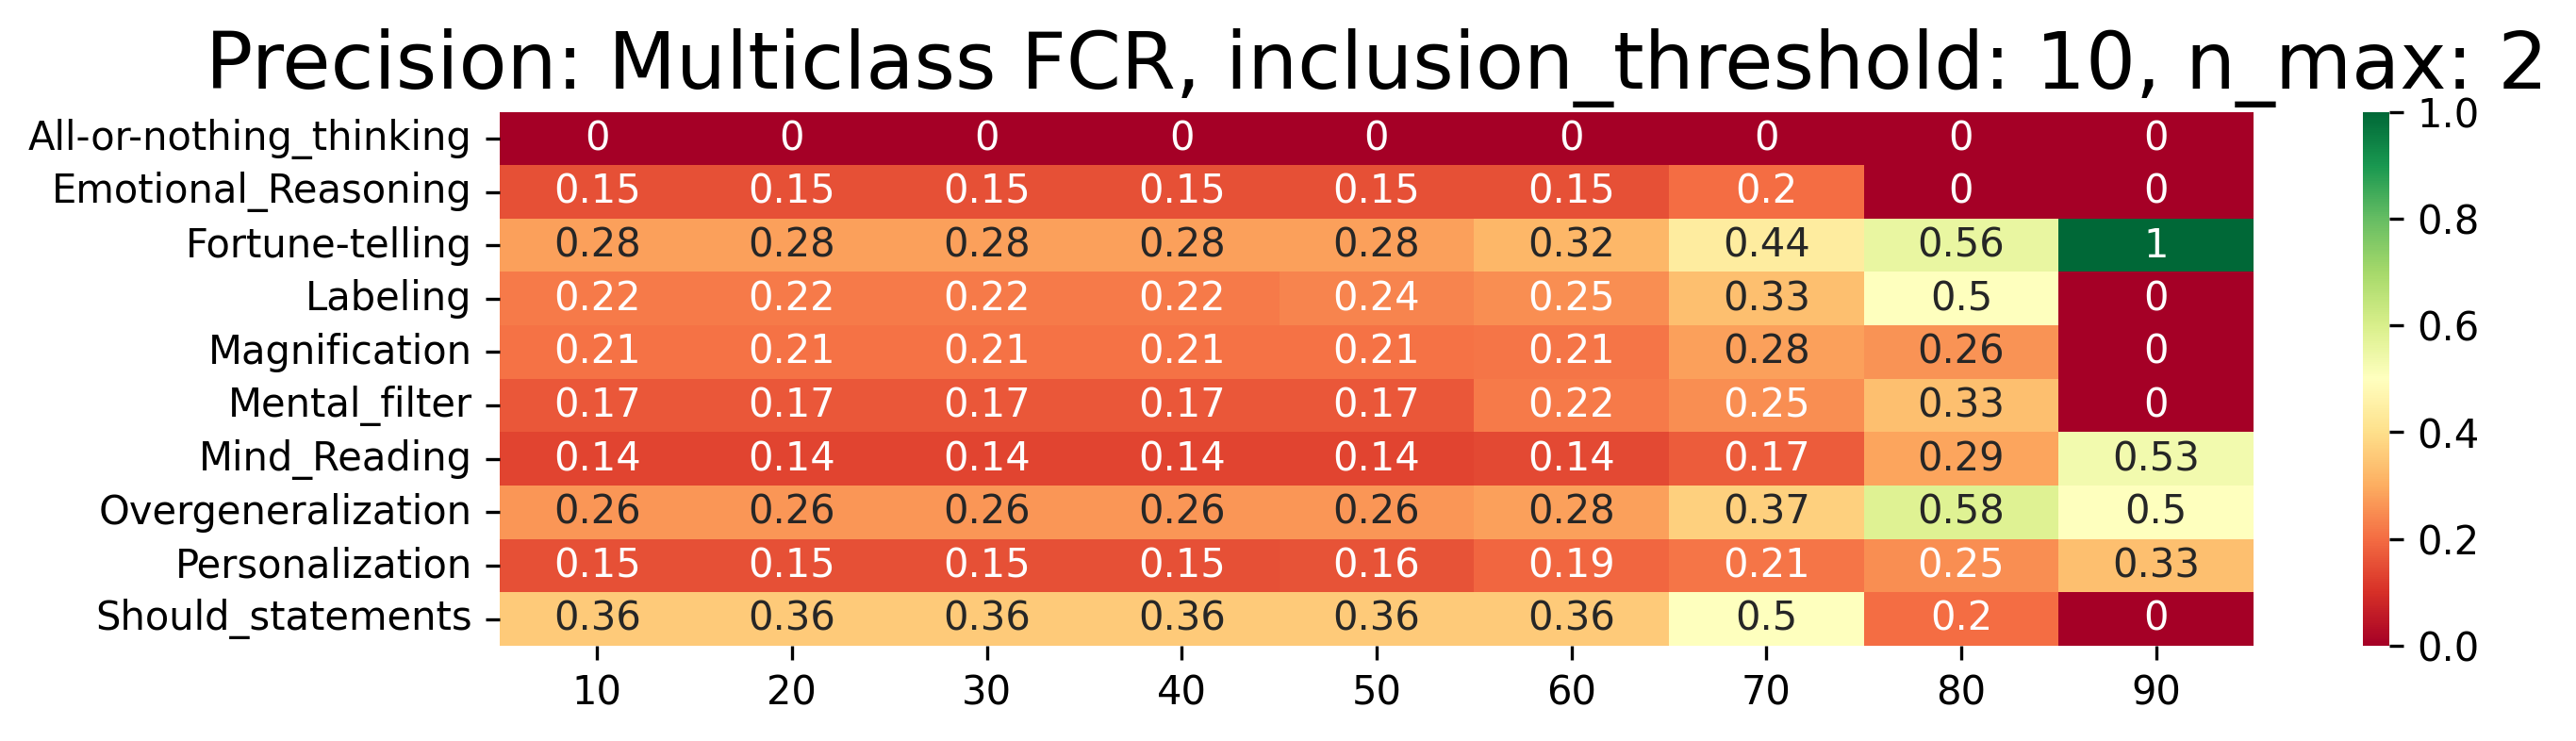

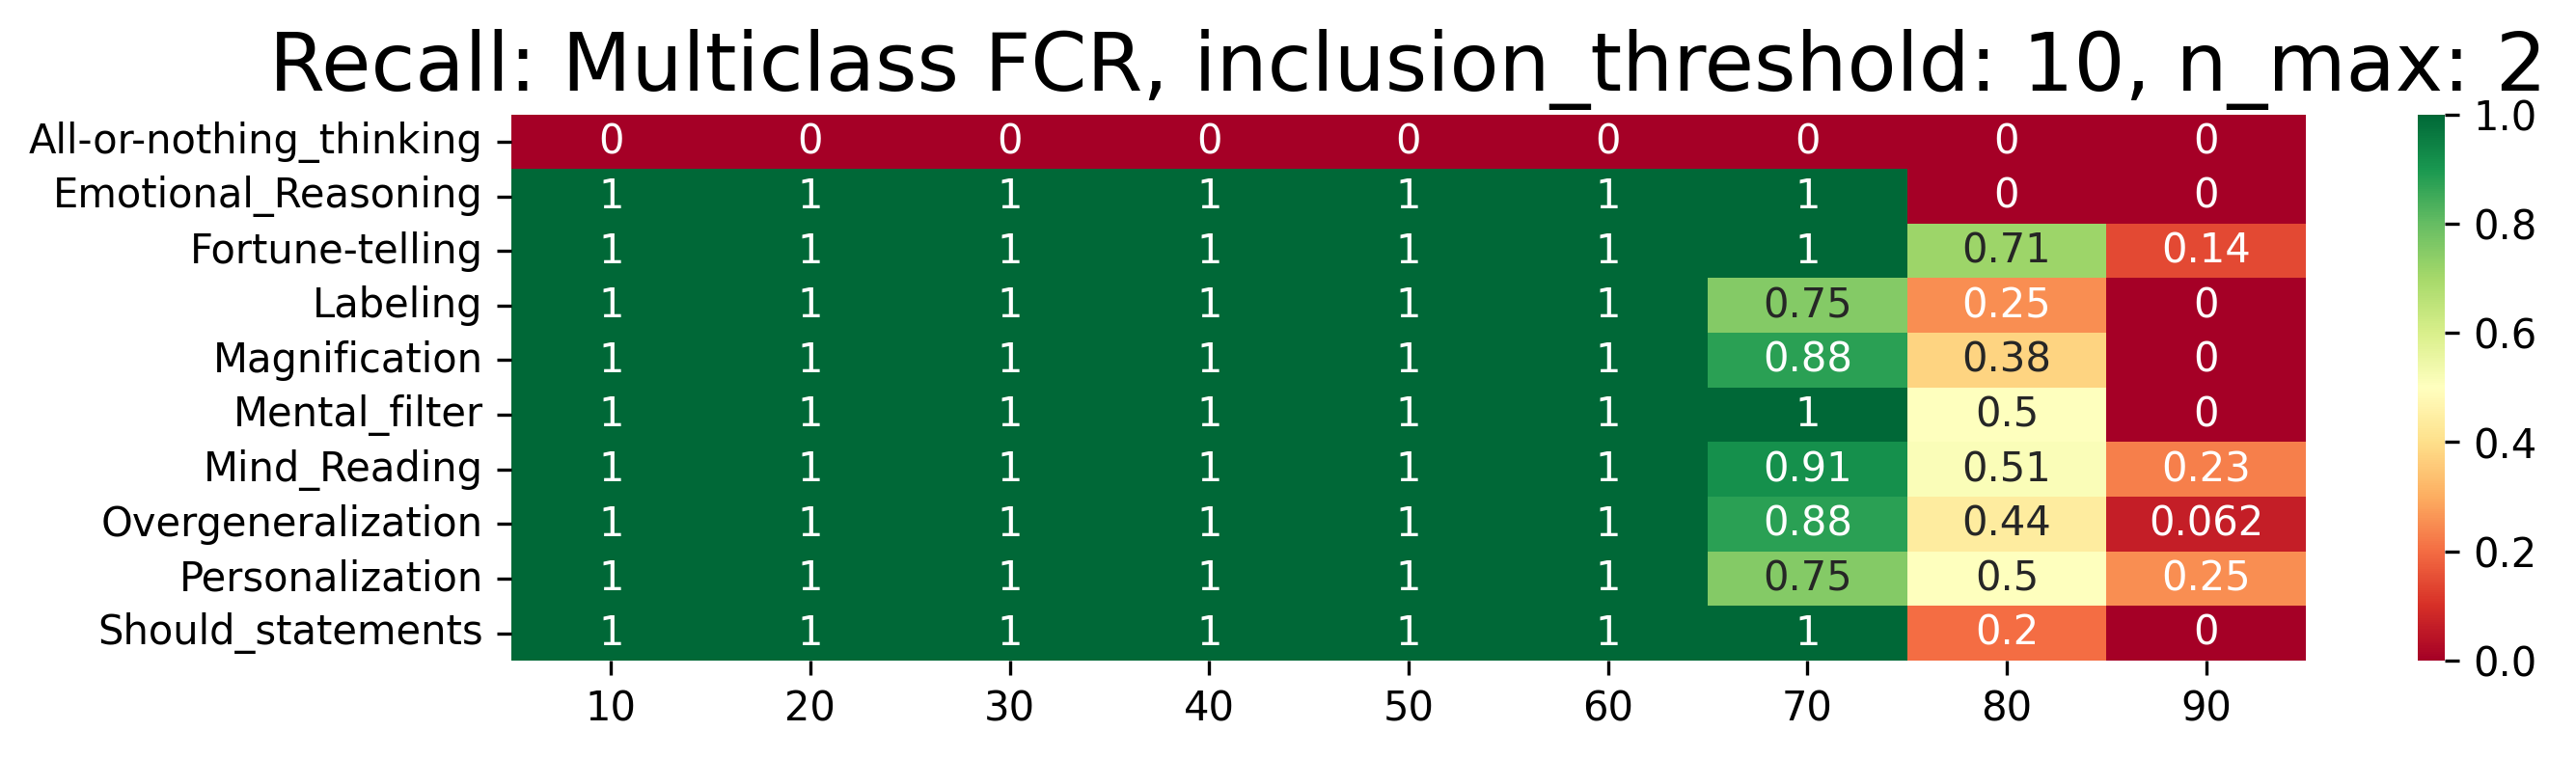

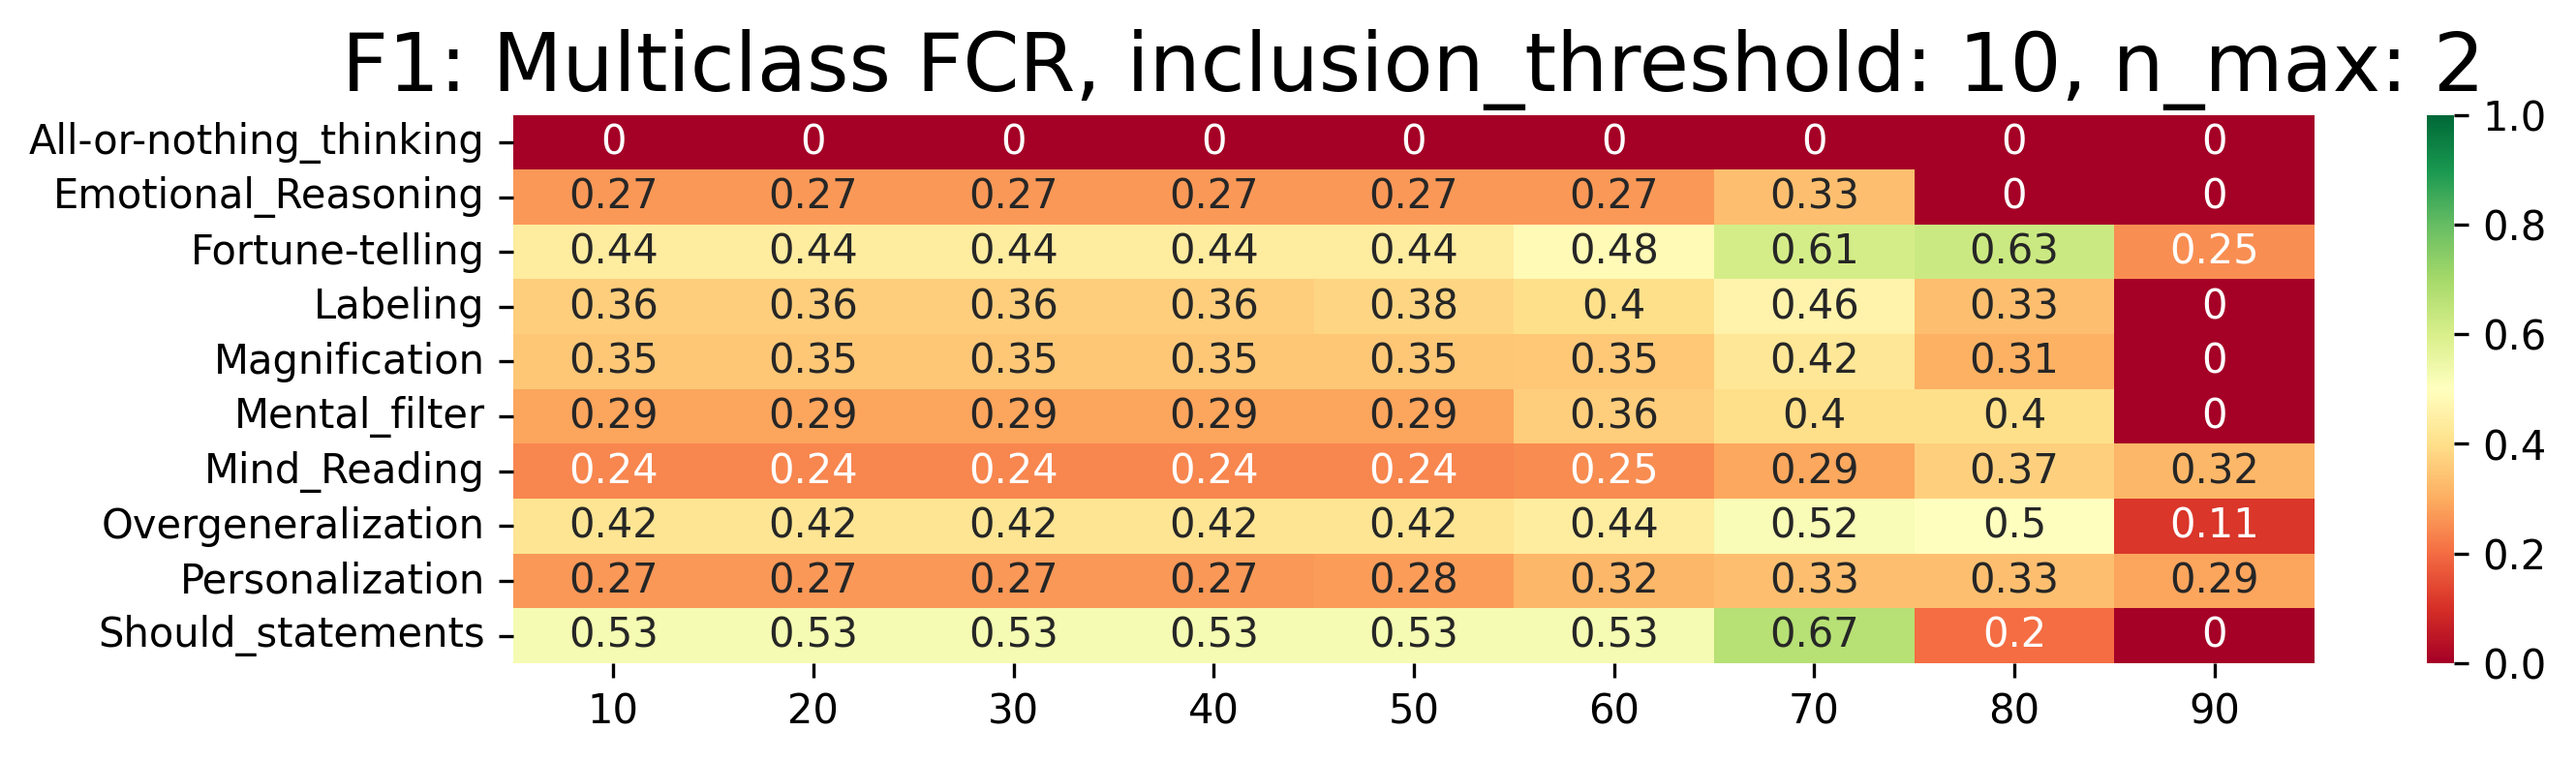

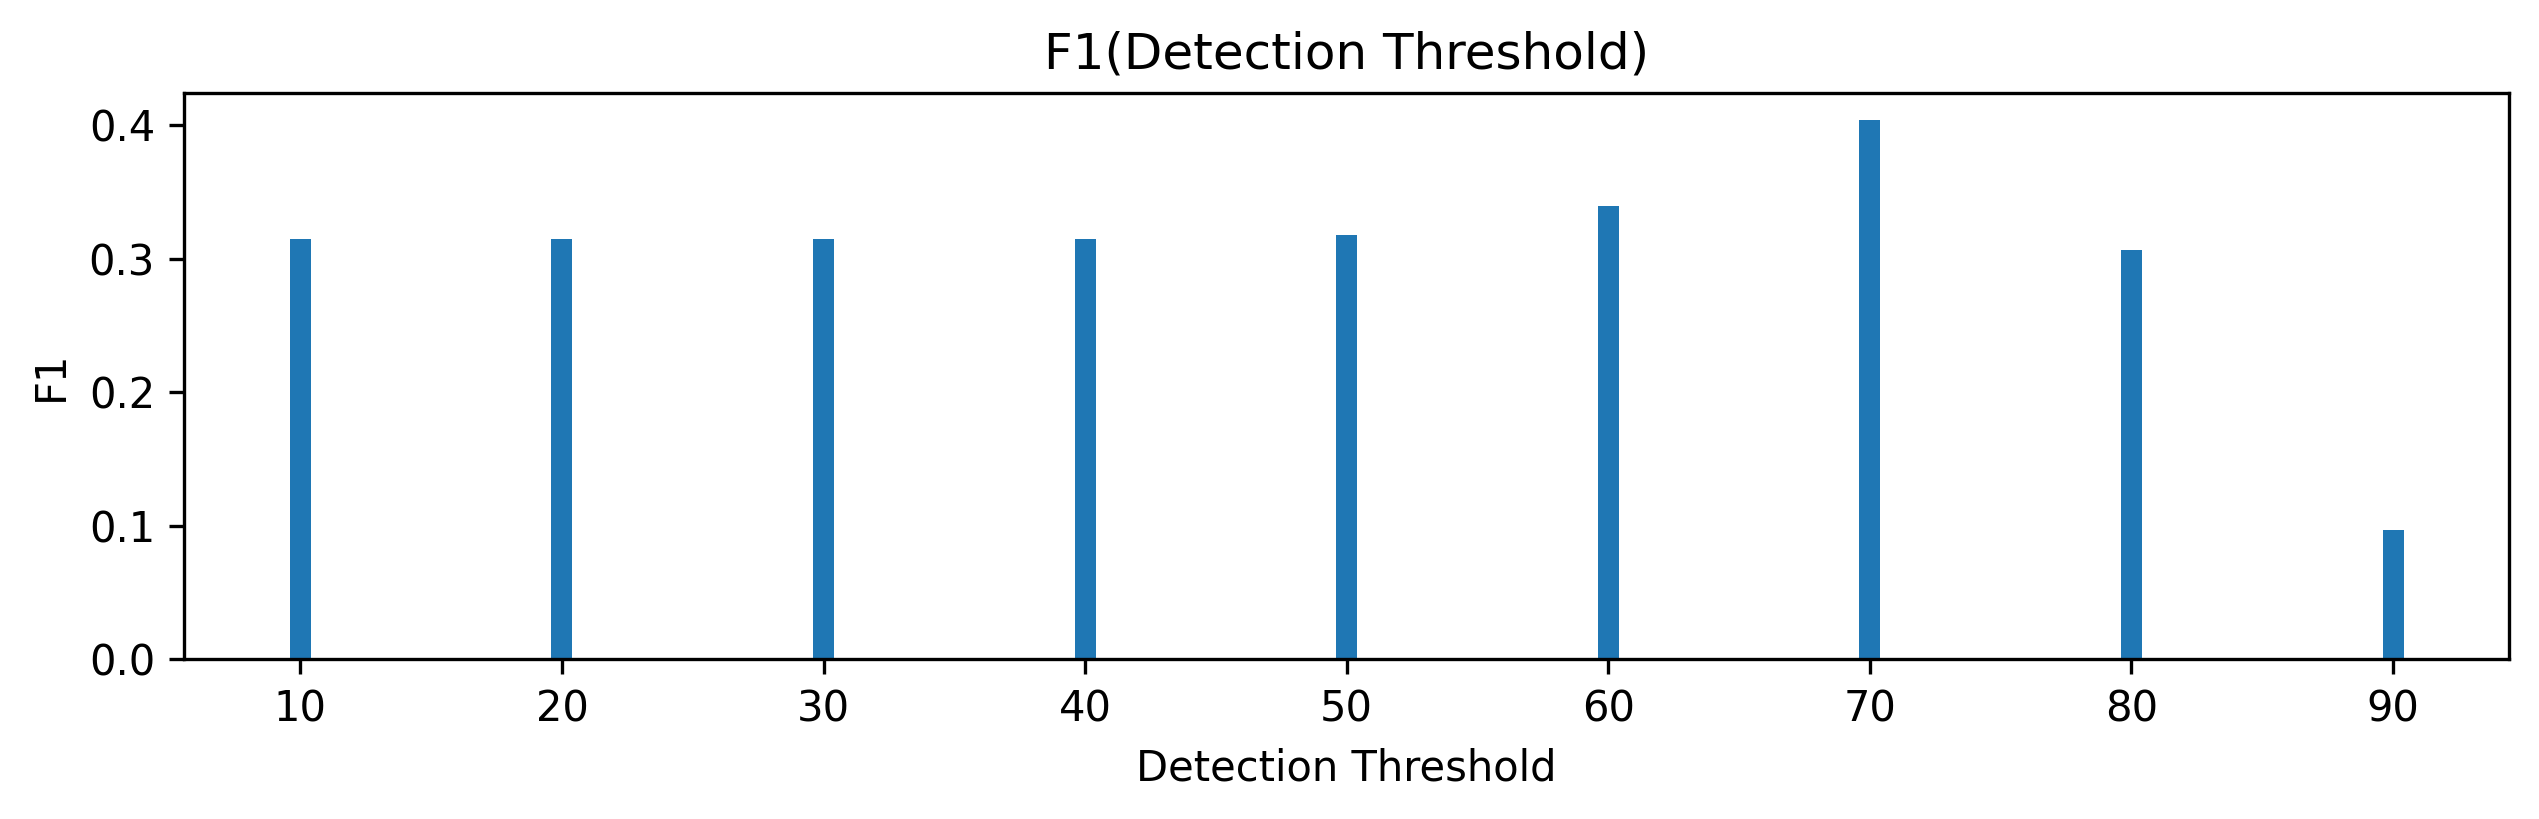

In [21]:
shift = 0
full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top1)

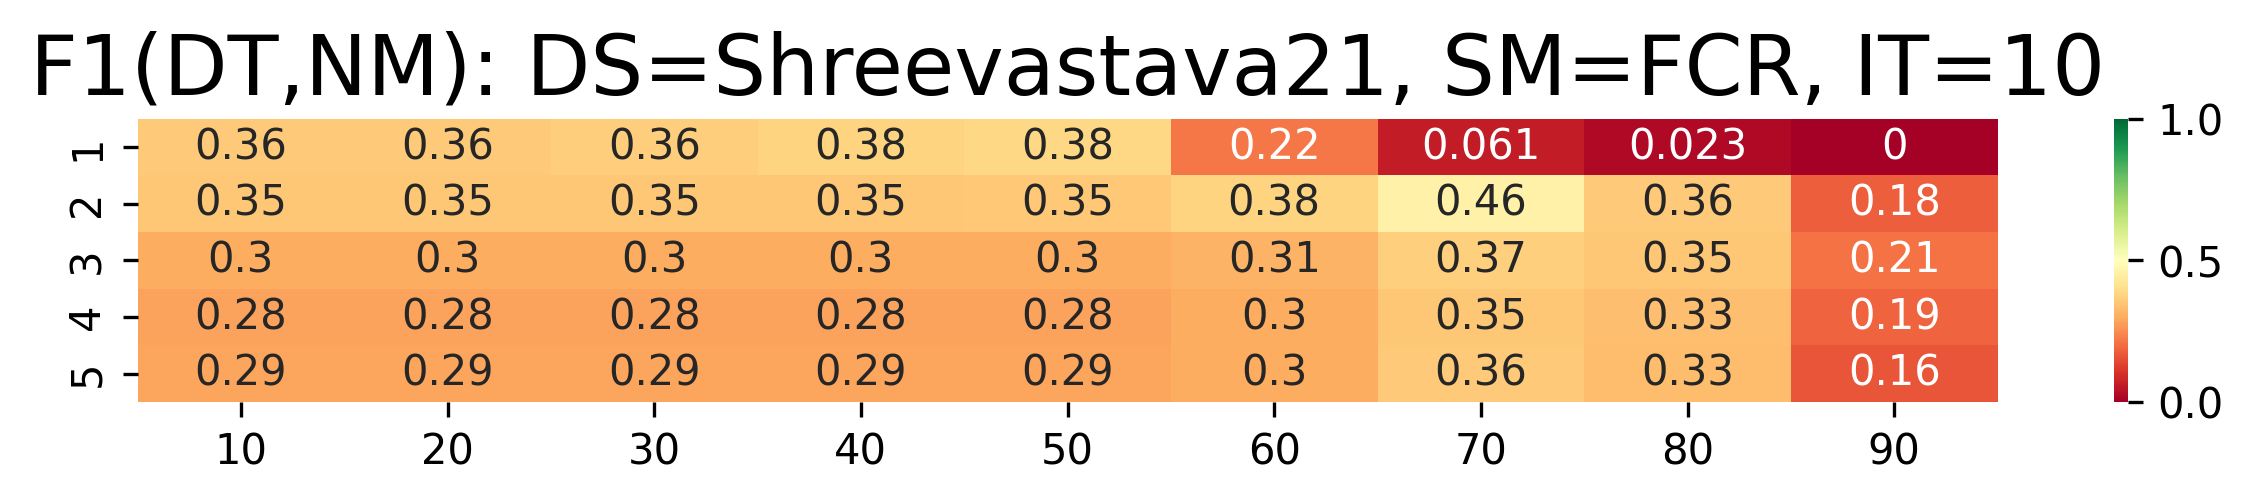

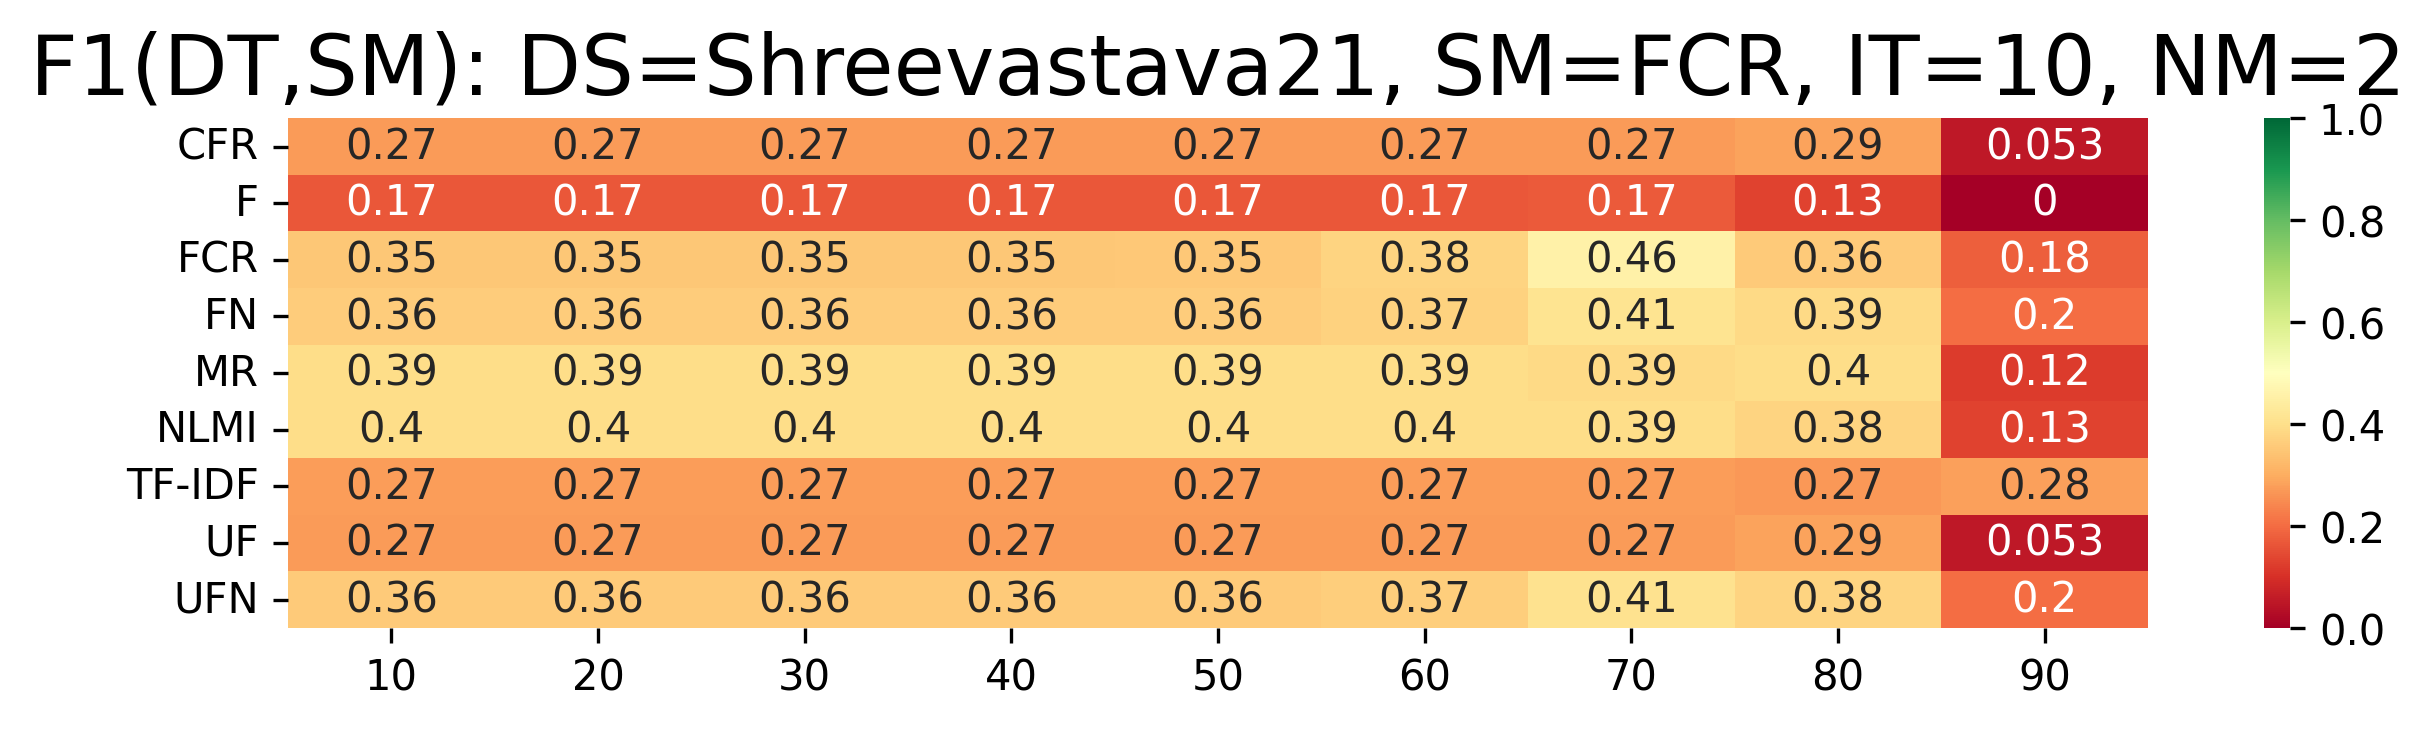

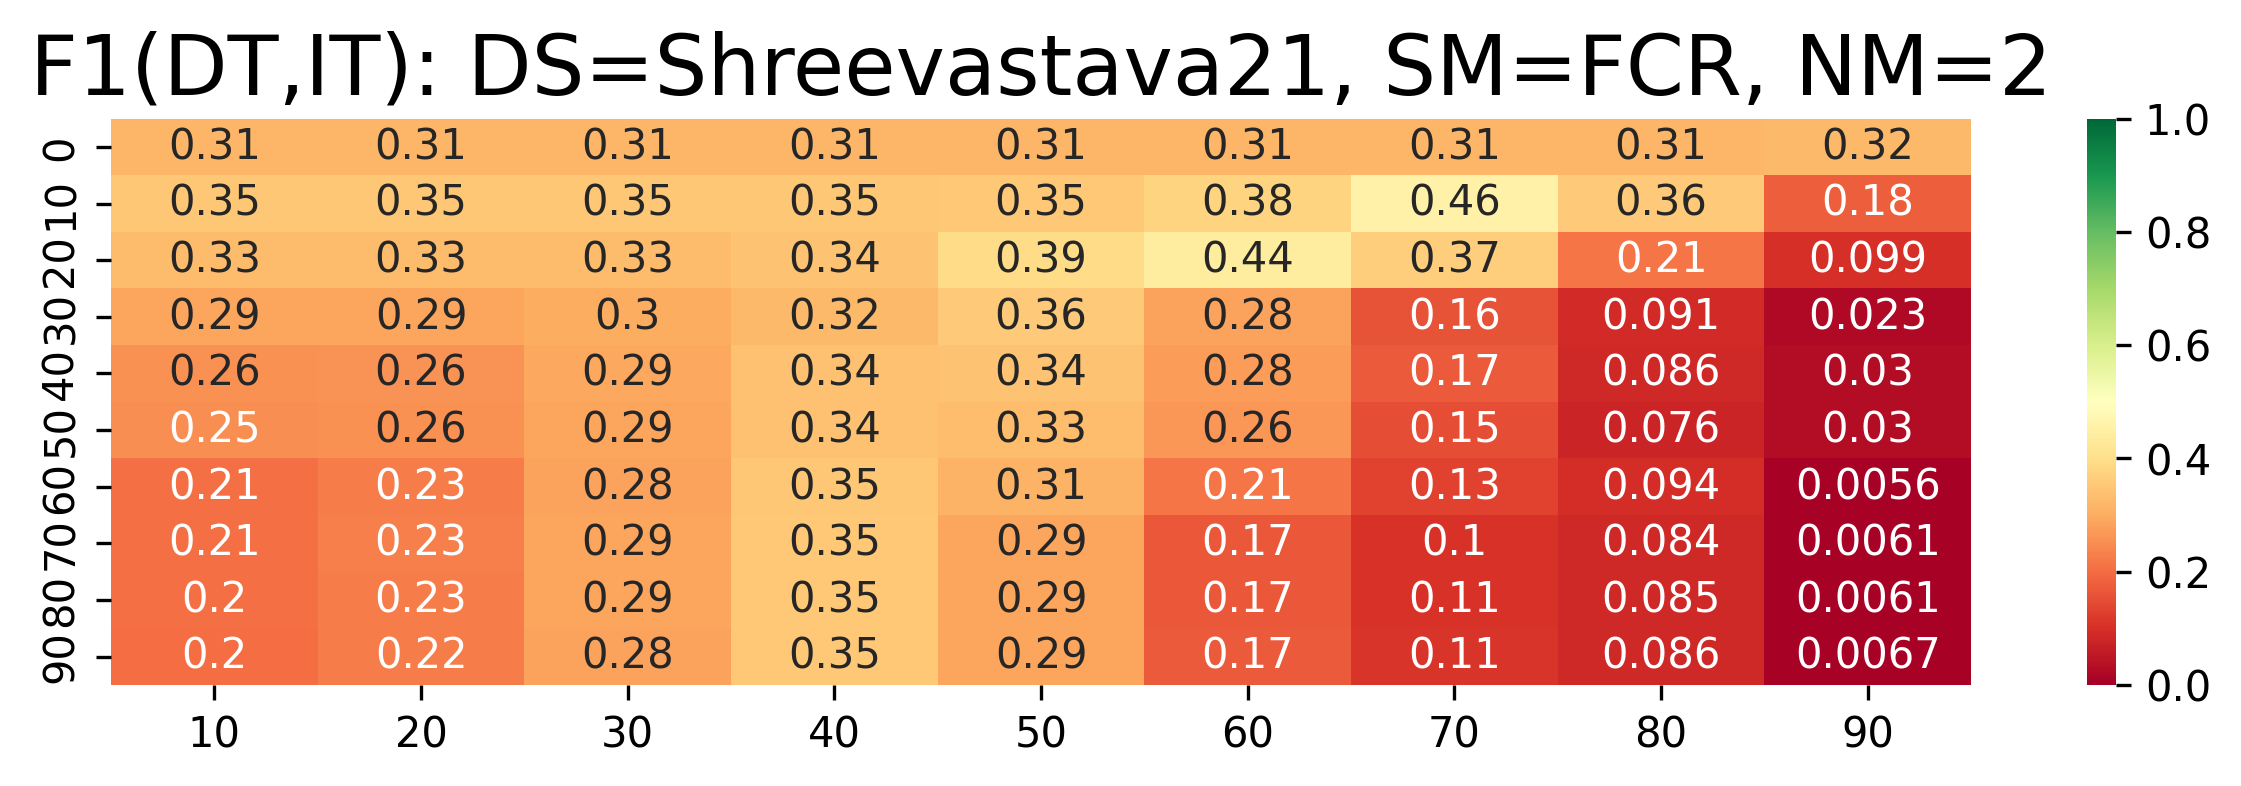

In [27]:
m = build_triple_matrix(summary,0,3,{2:SM,1:IT},6,n_max_values,detection_thresholds)
matrix_plot(n_max_values, detection_thresholds, m, 1.0, title = f'F1(DT,NM): DS={DS}, SM={SM}, IT={IT}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,2,3,{0:NM,1:IT},6,selection_metrics,detection_thresholds)
matrix_plot(sorted(selection_metrics), detection_thresholds, m, 1.0, title = f'F1(DT,SM): DS={DS}, SM={SM}, IT={IT}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,1,3,{0:NM,2:SM},6,inclusion_thresholds, detection_thresholds)
matrix_plot(sorted(inclusion_thresholds), detection_thresholds, m, 1.0, title = f'F1(DT,IT): DS={DS}, SM={SM}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)


## Summary

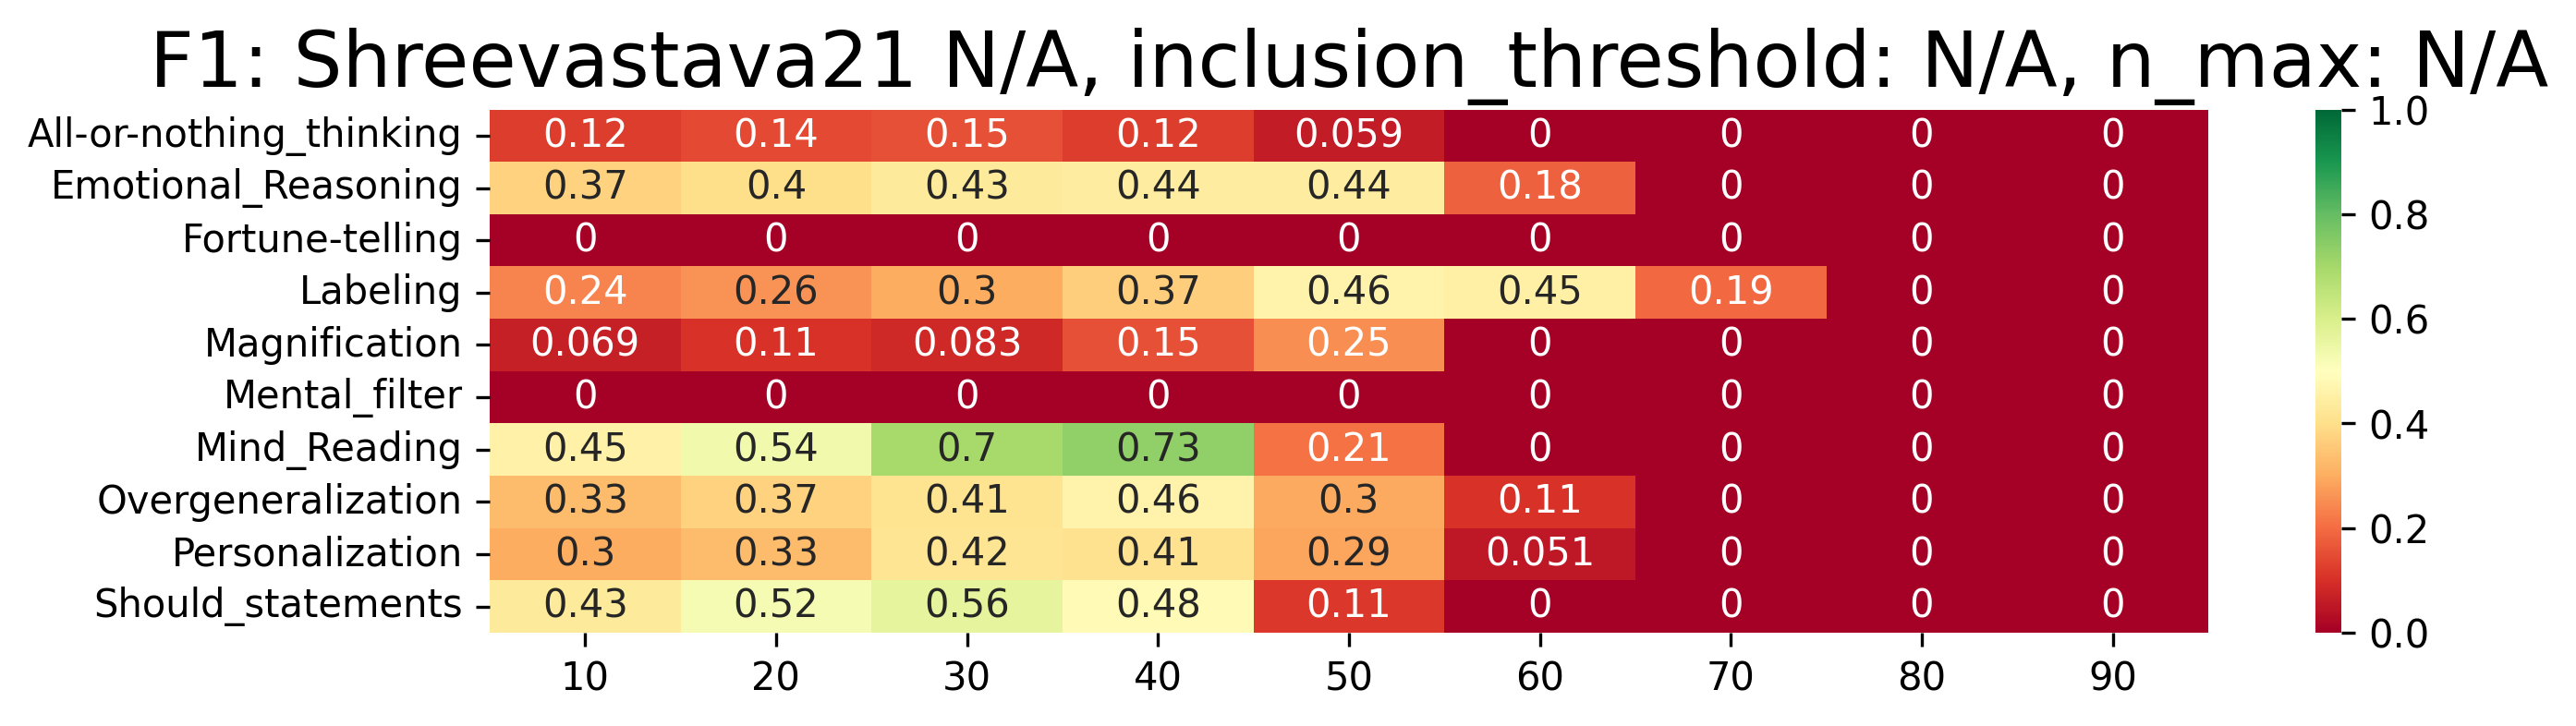

('N/A', 'N/A', 'N/A', 40, 0.316973235175538, {'All-or-nothing_thinking': 0.1218274111675127, 'Emotional_Reasoning': 0.44444444444444436, 'Fortune-telling': 0, 'Labeling': 0.36585365853658536, 'Magnification': 0.15384615384615385, 'Mental_filter': 0, 'Mind_Reading': 0.7333333333333333, 'Overgeneralization': 0.4615384615384615, 'Personalization': 0.4074074074074074, 'Should_statements': 0.4814814814814815})
['All-or-nothing_thinking', 'Emotional_Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental_filter', 'Mind_Reading', 'Overgeneralization', 'Personalization', 'Should_statements']
[0.12, 0.44, 0, 0.37, 0.15, 0, 0.73, 0.46, 0.41, 0.48]


In [106]:
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_filenames,path):
    metrics = {}
    for m in metrics_filenames:
        filename = metrics_filenames[m] if type(metrics_filenames) == dict else m
        metrics[m] = path + lang + '/' + filename + '.txt'
    return metrics

tm_base = TextMetrics(language_metrics('',all_metricsmap,path='data/models/distortions/ours')
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)

detection_thresholds = [10,20,30,40,50,60,70,80,90]

accumulator = []
evaluate_metrics(tm_base, df, 'N/A', detection_thresholds, DS, list(all_metricsmap), n_max='N/A', 
                selection_metric = 'N/A', f1_score=True, evaluator=our_evaluator_top1, accumulator=accumulator)

best = sorted(accumulator, key=lambda x: (-x[4]))[0]
print(best)
labels = sorted(list(best[5]))
print(labels)
numbers_arinicheva = [round(best[5][label],2) for label in labels]
print(numbers_arinicheva)

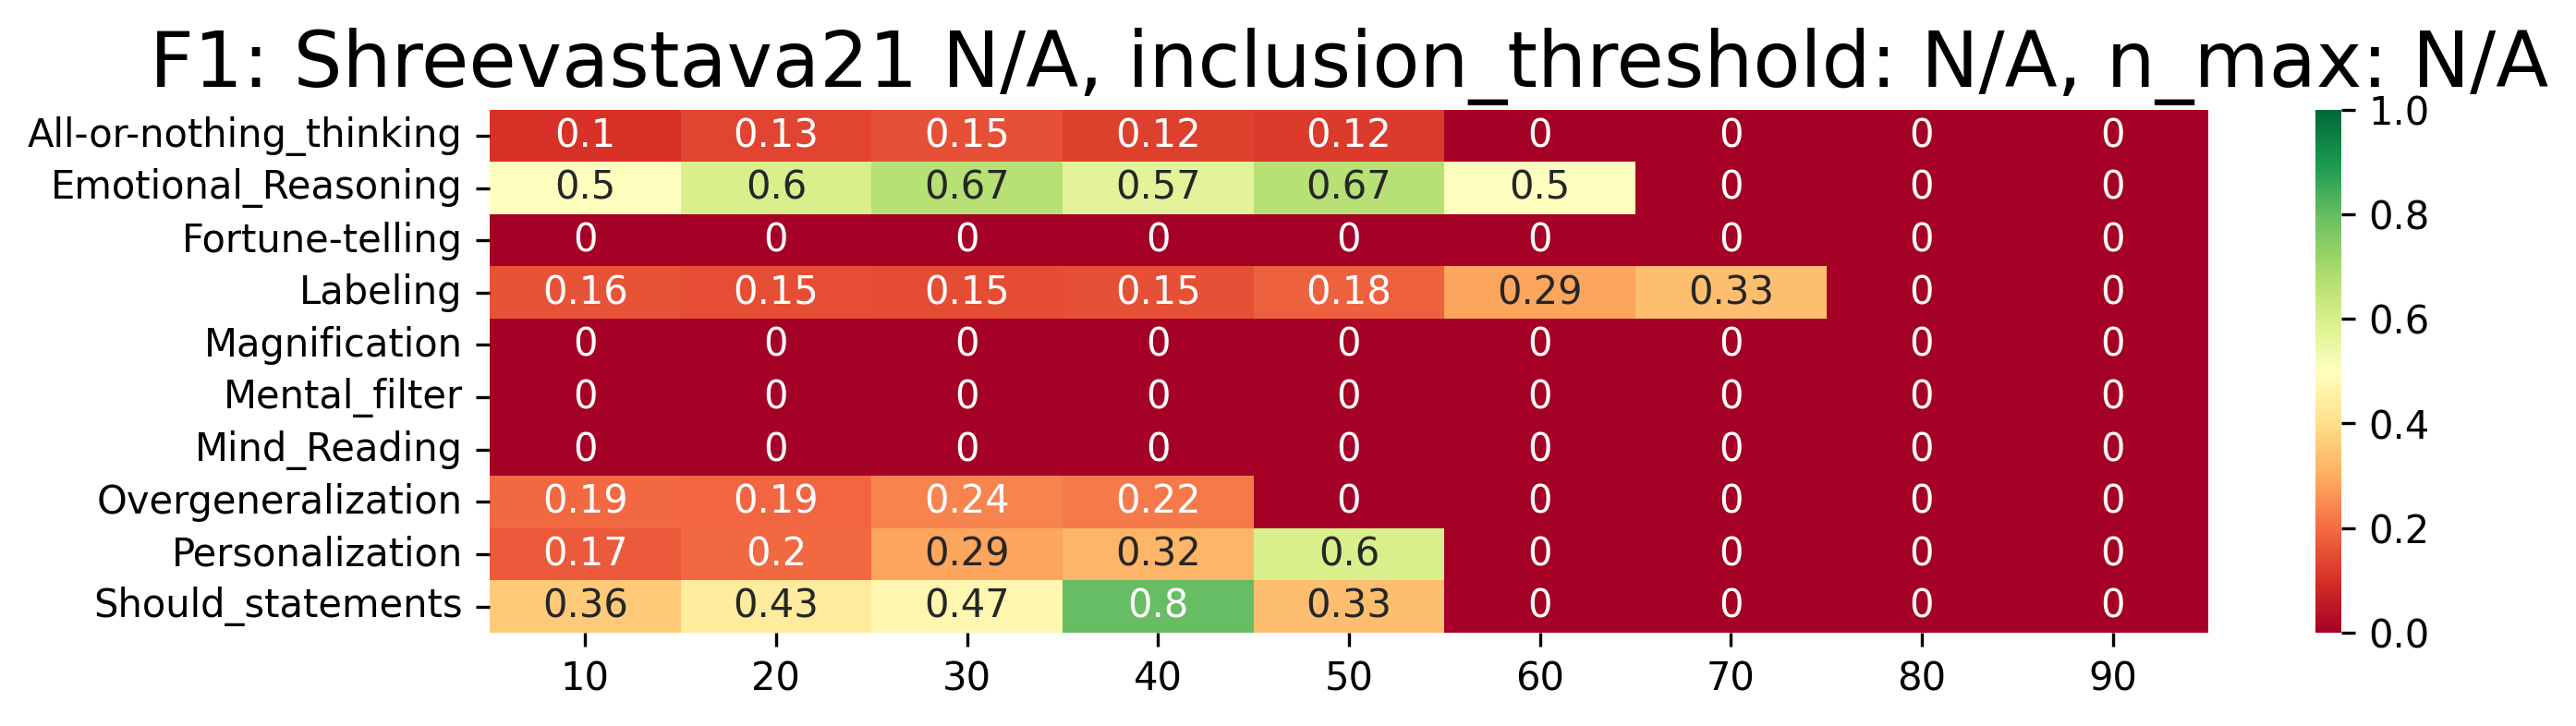

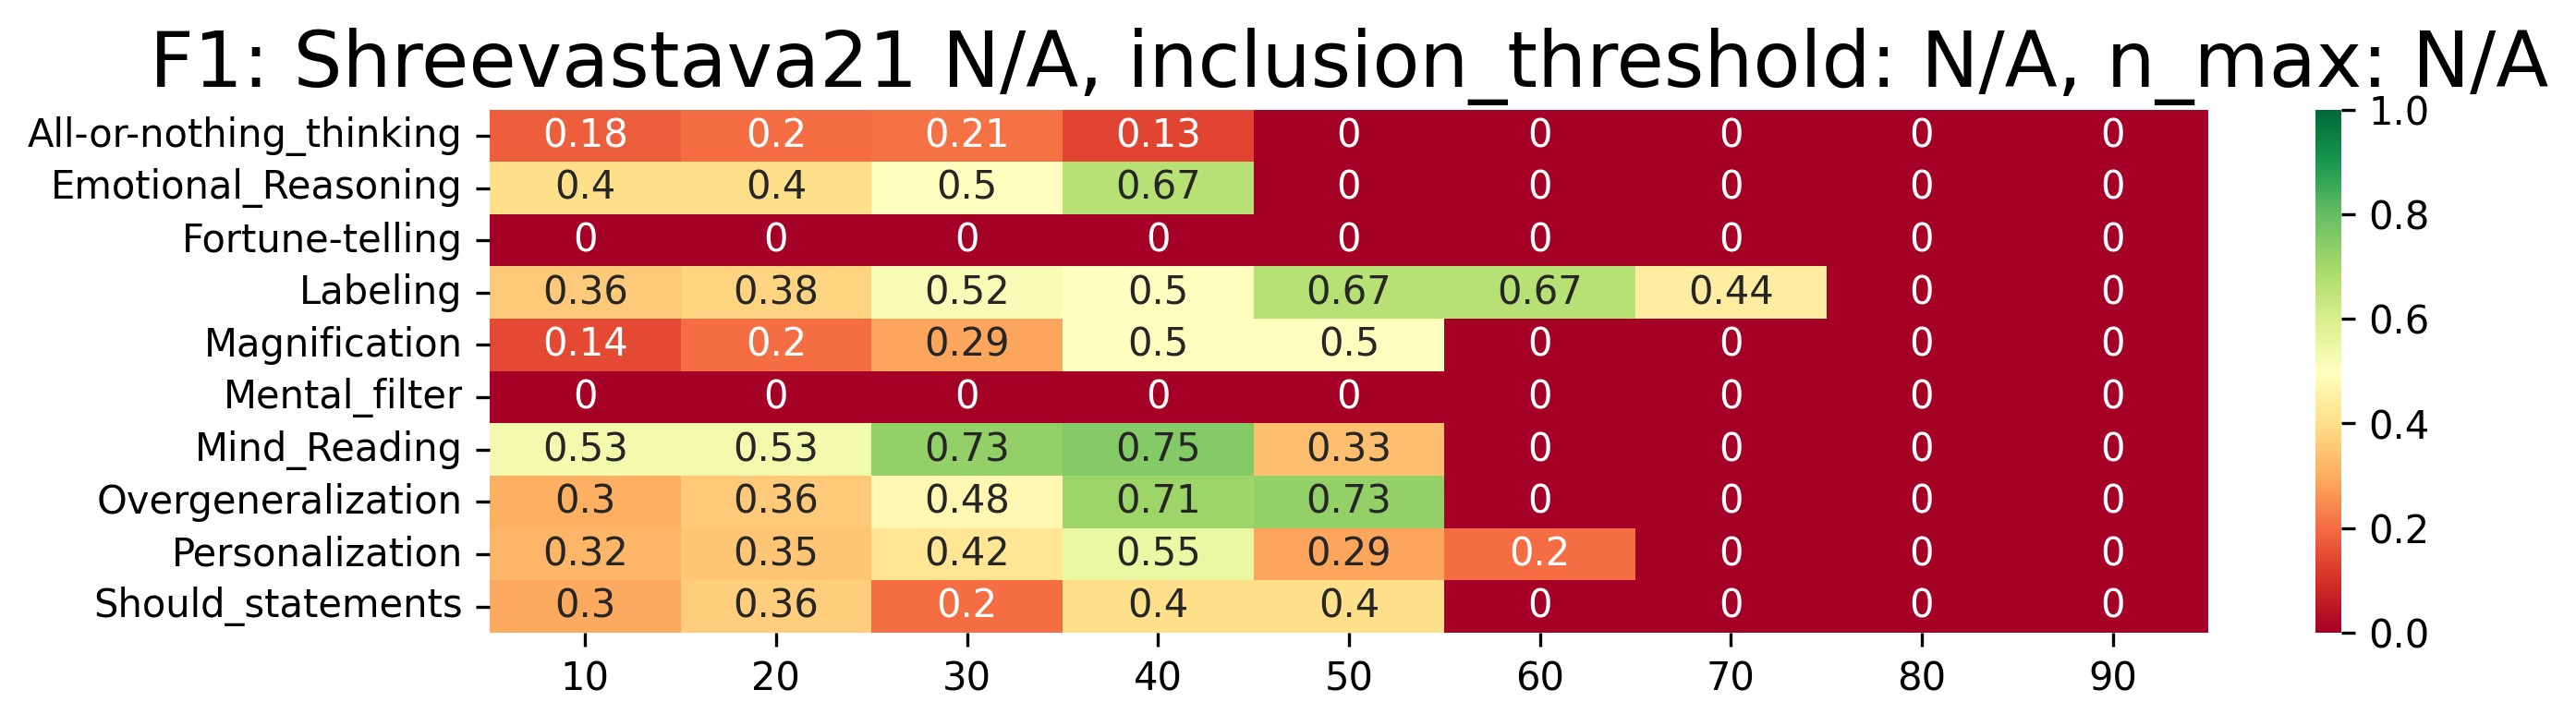

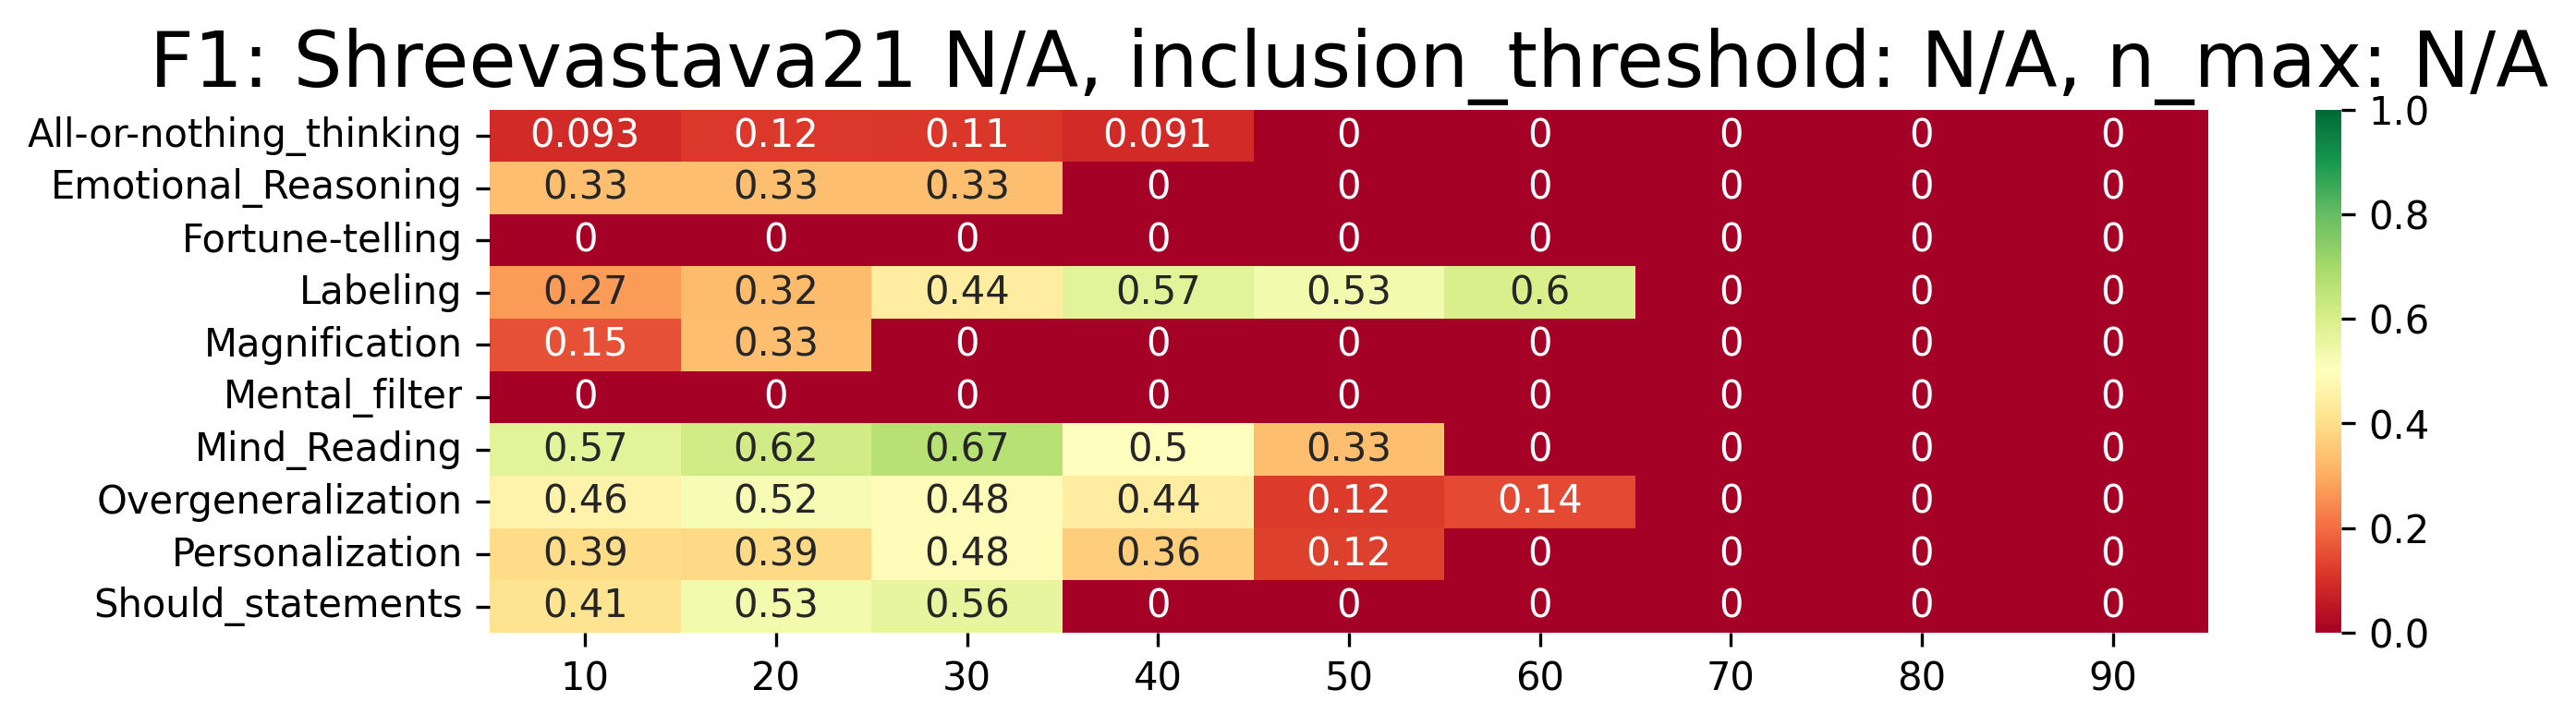

In [107]:
validation_fraction = 5
results_base = []
for shift in splits:
    test_df  = df[(df.index + shift) % validation_fraction == 0]
    accumulator_base = []
    evaluate_metrics(tm_base, test_df, 'N/A', detection_thresholds, DS, list(all_metricsmap), n_max='N/A', 
                selection_metric = 'N/A', f1_score=True, evaluator=our_evaluator_top1, accumulator=accumulator_base)
    results_base.append(accumulator_base)

In [109]:
summary_base = []
for l1,l2,l3 in zip(results_base[0],results_base[1],results_base[2]):
    summary_base.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary_base = sorted(summary_base, key=lambda x: (-x[6],x[3])) # sort by -F1avg, DT
summary_base[0]

('N/A',
 'N/A',
 'N/A',
 30,
 0.19602576073164307,
 0.3335602984440194,
 0.2794120518819945,
 19.895656036475824)

In [82]:
base_babakan = {'Mind_Reading': 0.6415,
'Should_statements': 0.4615,
'All-or-nothing_thinking': 0.2041,
'Overgeneralization': 0.4928,
'Mental_filter': 0.0000,
'Magnification': 0.0000,
'Emotional_Reasoning': 0.1250,
'Personalization': 0.3913,
'Fortune-telling': 0.4348,
'Labeling': 0.5000}
numbers_babakan = [round(base_babakan[label],2) for label in labels]
print(numbers_babakan)

[0.2, 0.12, 0.43, 0.5, 0.0, 0.0, 0.64, 0.49, 0.39, 0.46]


2 10 FCR 70
Shift=0: train=2024, test=506
Labels count: defaultdict(<class 'int'>, {'Labeling': 162, 'Emotional_Reasoning': 134, 'No_Distortion': 747, 'Fortune-telling': 162, 'Magnification': 192, 'Mind_Reading': 248, 'Personalization': 158, 'All-or-nothing_thinking': 101, 'Overgeneralization': 218, 'Mental_filter': 121, 'Should_statements': 108})


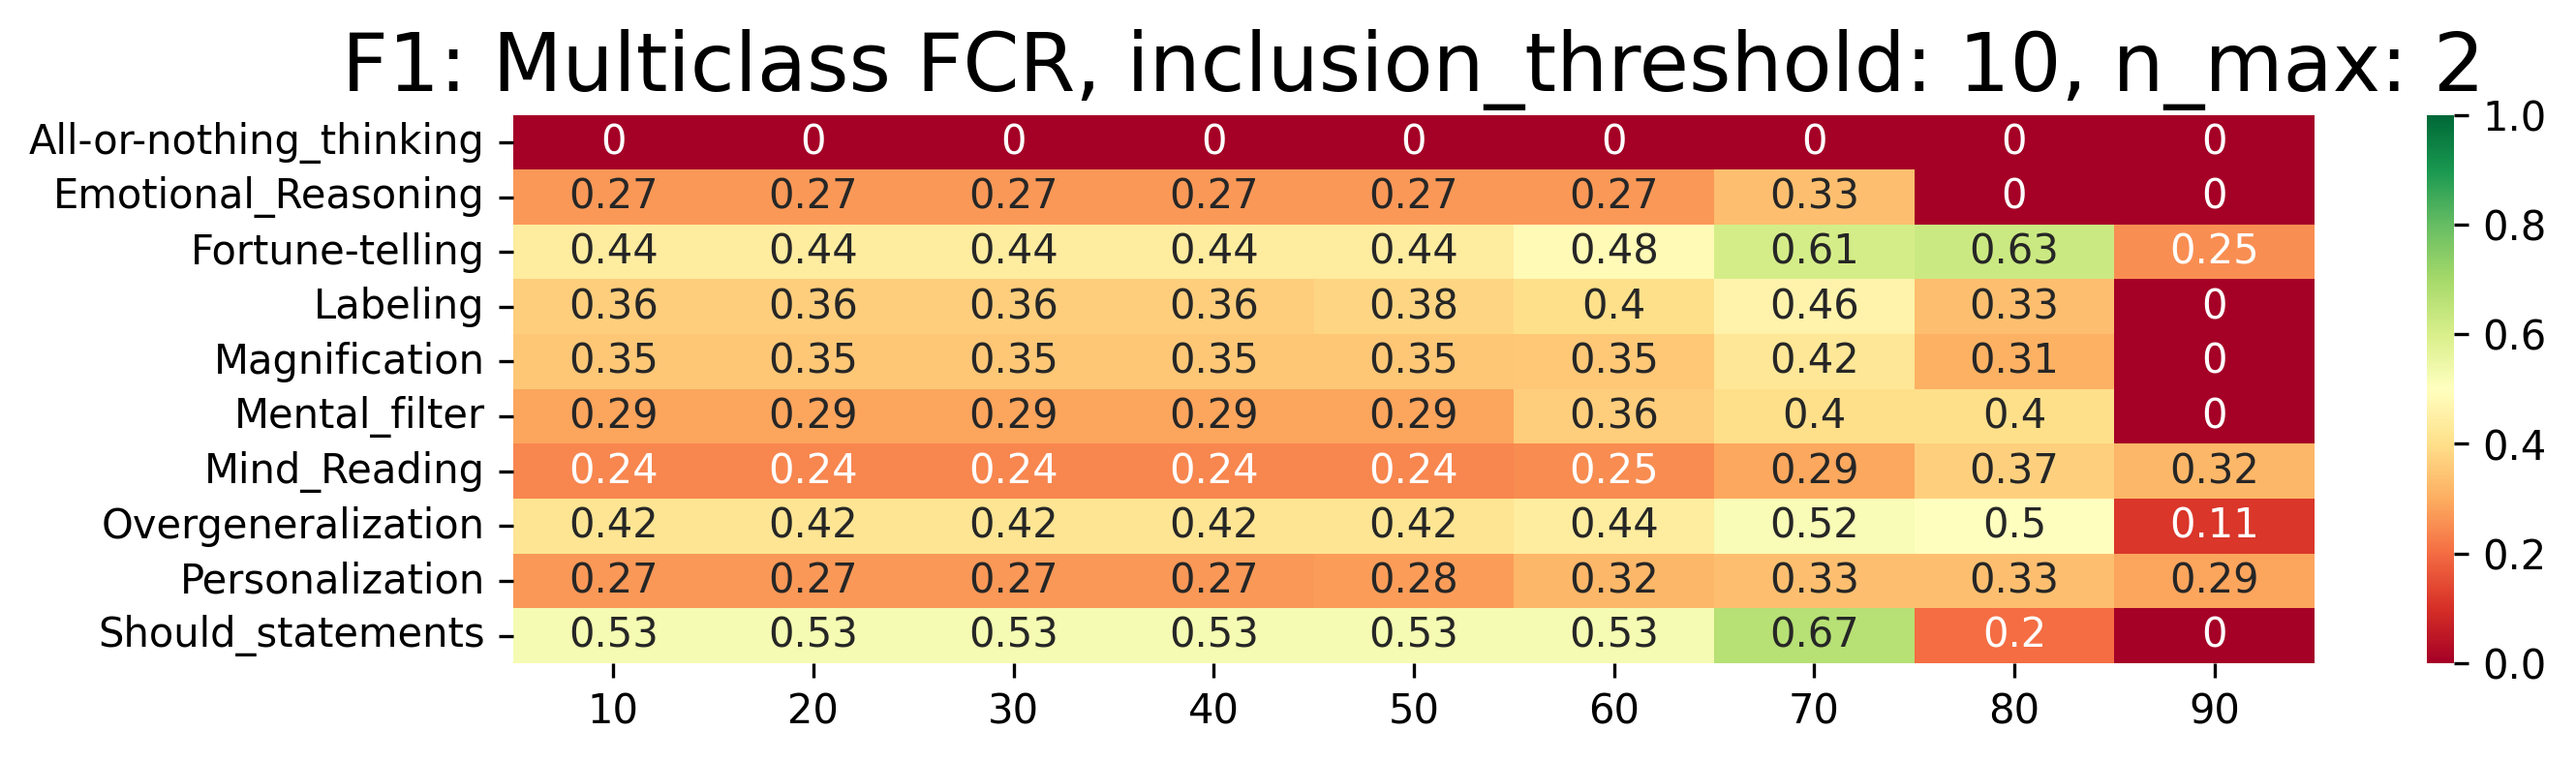

(2, 10, 'FCR', 70, 0.4038565832729025, {'All-or-nothing_thinking': 0, 'Emotional_Reasoning': 0.33333333333333337, 'Fortune-telling': 0.6086956521739131, 'Labeling': 0.46153846153846156, 'Magnification': 0.42424242424242425, 'Mental_filter': 0.4, 'Mind_Reading': 0.2922374429223744, 'Overgeneralization': 0.5185185185185185, 'Personalization': 0.3333333333333333, 'Should_statements': 0.6666666666666666})
['All-or-nothing_thinking', 'Emotional_Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental_filter', 'Mind_Reading', 'Overgeneralization', 'Personalization', 'Should_statements']
[0, 0.33, 0.61, 0.46, 0.42, 0.4, 0.29, 0.52, 0.33, 0.67]


In [83]:
print(NM,IT,SM,DT) # 2 10 FCR 70
shift = 0

accumulator = []
full_test_circle(df,test_kaggle_multiclass_path,f'multi-df-shreevastava-split-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                f1_score=True, split_shift=shift, evaluator=our_evaluator_top1, accumulator=accumulator)

best = sorted(accumulator, key=lambda x: (-x[4]))[0]
print(best)
labels = sorted(list(best[5]))
print(labels)
numbers_ours = [round(best[5][label],2) for label in labels]
print(numbers_ours)

In [84]:
metric_names = labels
model_metrics = {
'babakan25':   numbers_babakan,
'arinicheva25':   numbers_arinicheva,
'ours25': numbers_ours
}
fig = go.Figure()
for i in range(len(labels)):
    fig.add_trace(go.Bar(
        name=metric_names[i],
        x=list(model_metrics), y=[model_metrics[m][i] for m in model_metrics],
    ))
fig.update_layout(
    barmode='group', # Group bars by model
    title='F1 by model and label', # Add a title
    xaxis_title='Model', # Label the x-axis
    yaxis_title='F1', # Label the y-axis
    hovermode='closest' # Improve hover behavior
)
fig.show()

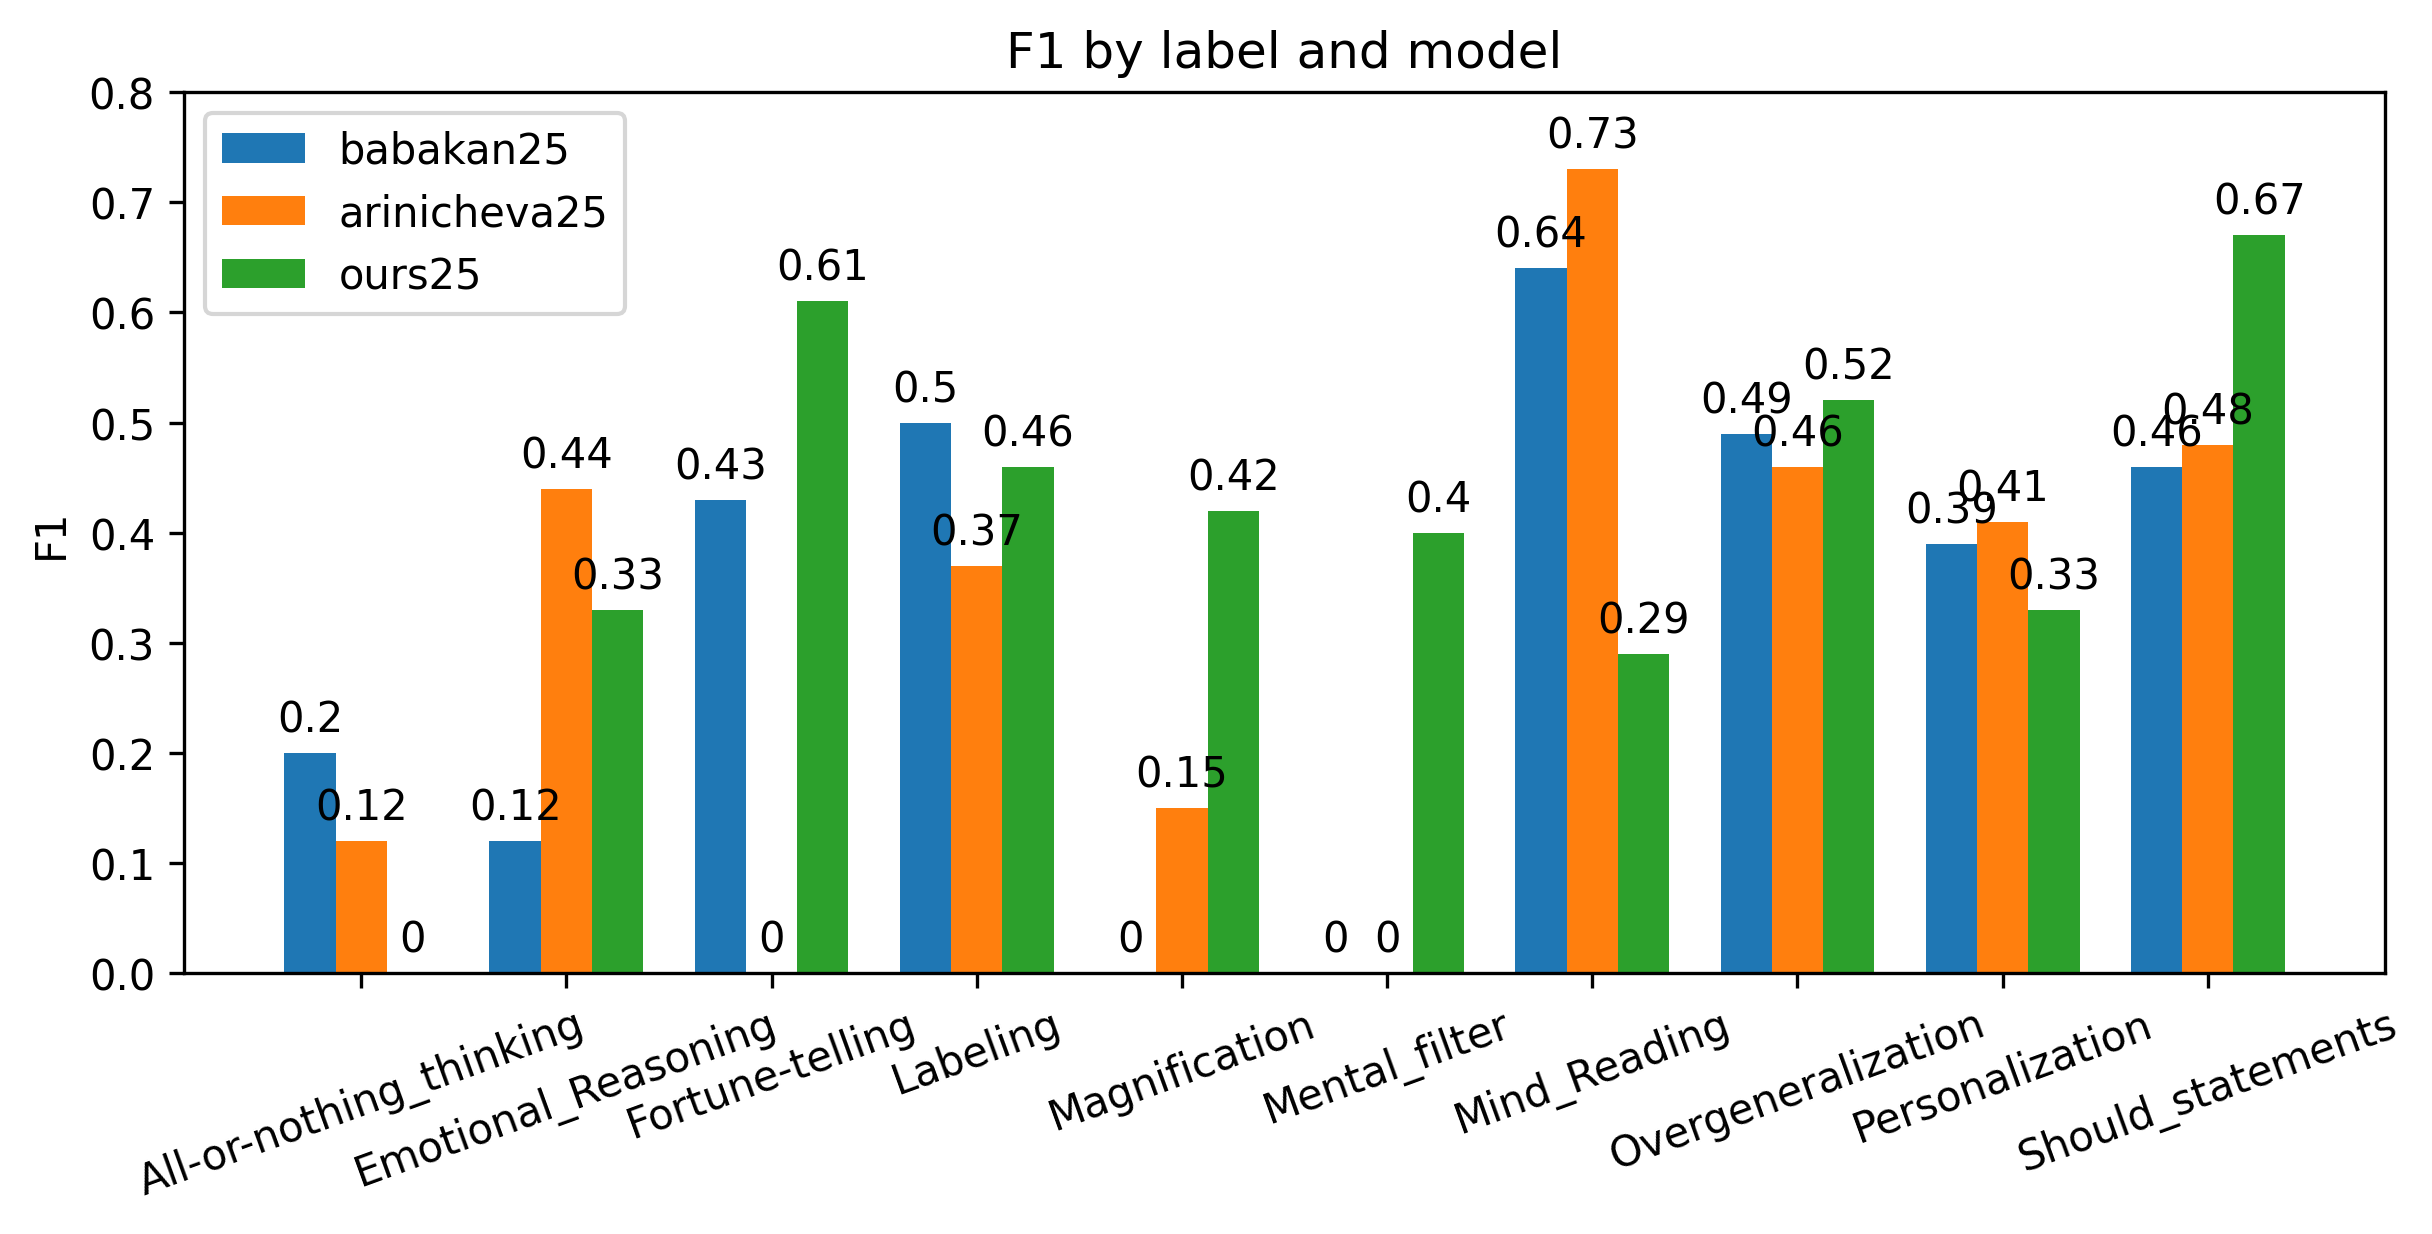

In [104]:
values = {
'babakan25':   numbers_babakan,
'arinicheva25':   numbers_arinicheva,
'ours25': numbers_ours
}

plt.rcParams["figure.figsize"] = (8,4)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_title('F1 by label and model')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left')#, ncols=3)
ax.set_ylim(0, 0.8)
ax.tick_params(axis='x', rotation=20)
fig.set_dpi(300)

plt.show()

F1 babakan25: 0.4467
F1 arinicheva25: 0.2794120518819945%
F1 ours25: 0.4550365307616822%
MPE arinicheva25: 19.895656036475824%
MPE ours25: 7.498291386717158%


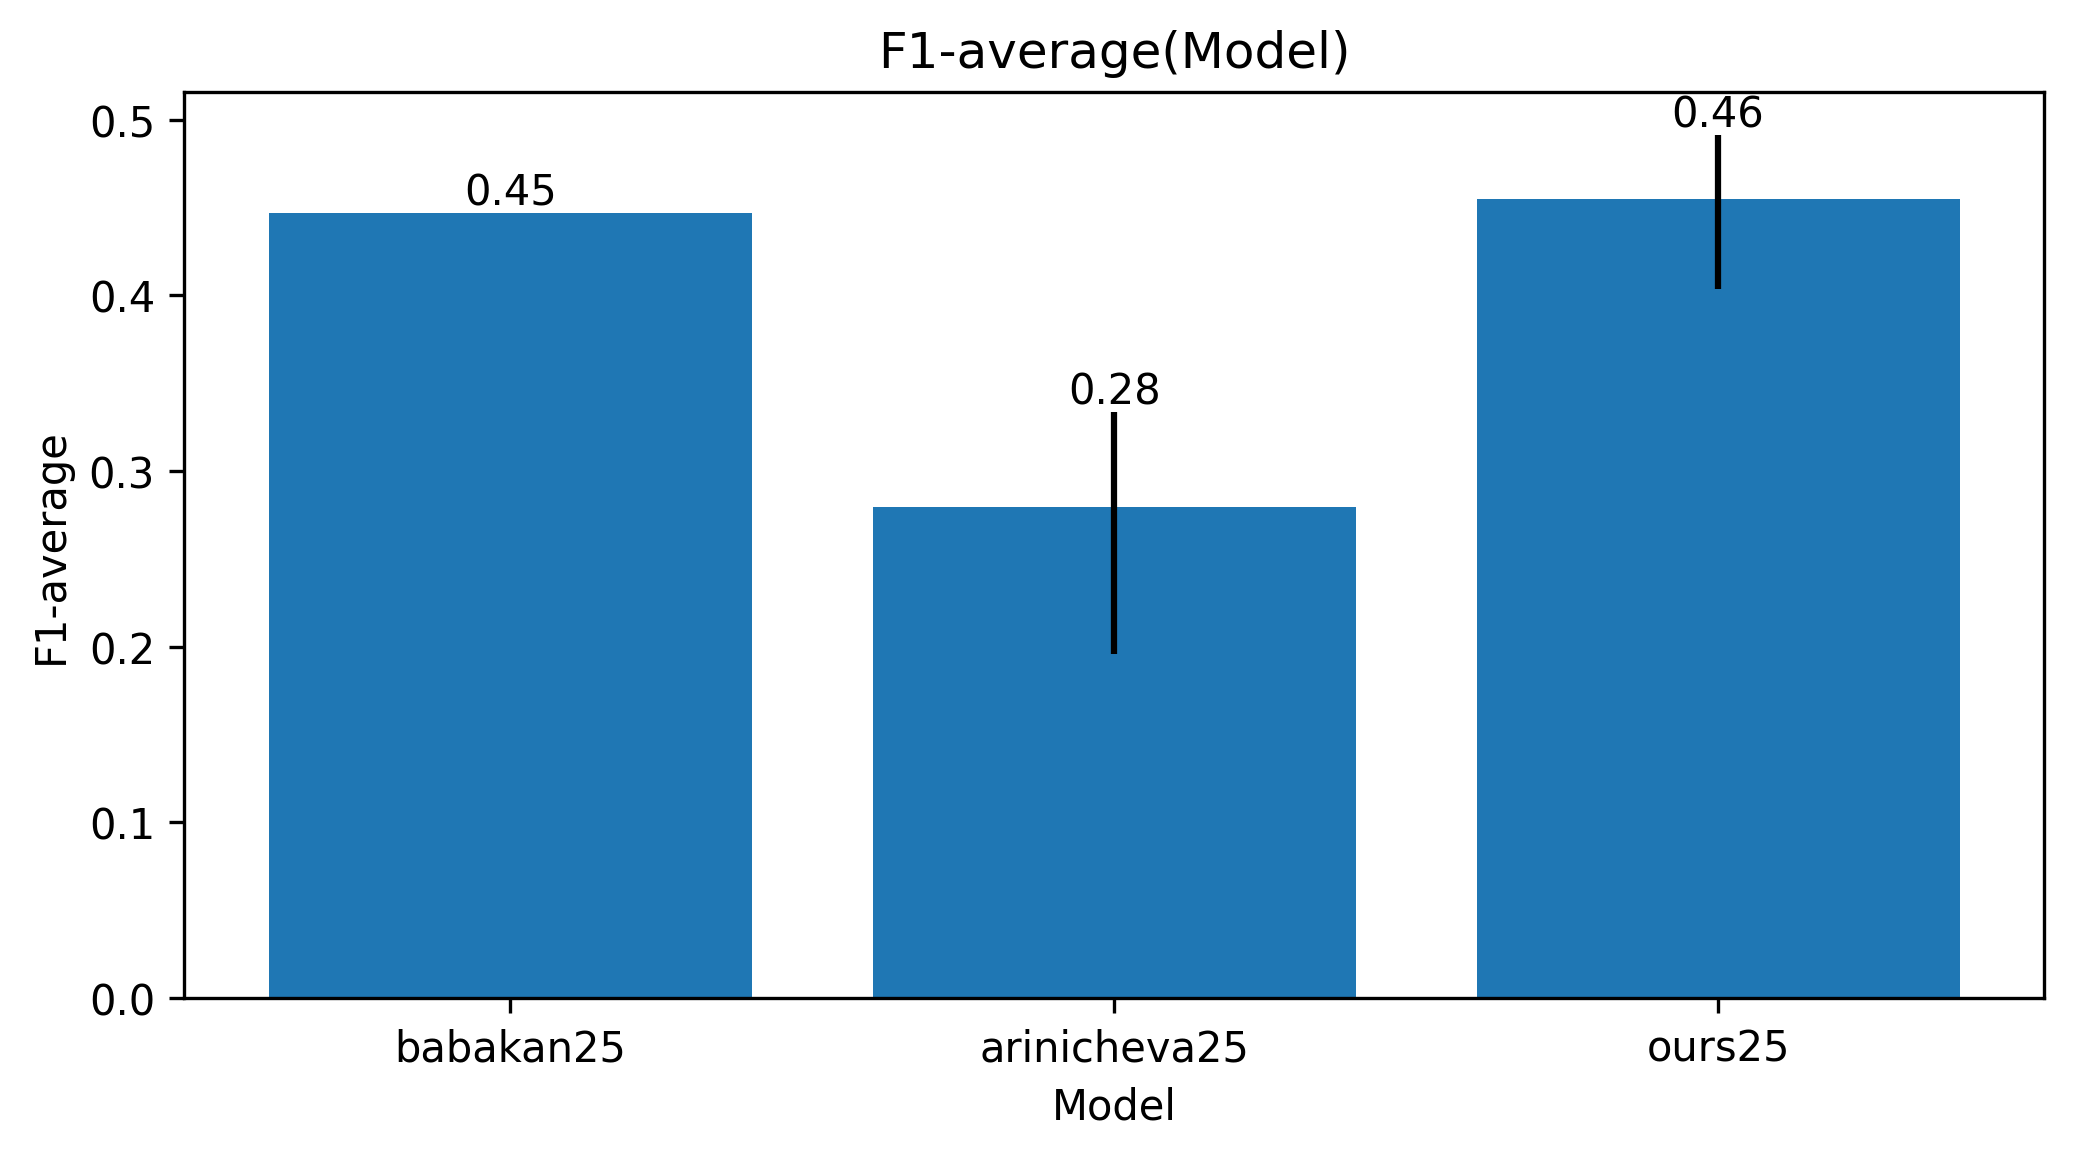

In [118]:
# https://dergipark.org.tr/tr/download/article-file/3865878, page 7
print(f'F1 babakan25: 0.4467')
print(f'F1 arinicheva25: {summary_base[0][6]}%')
print(f'F1 ours25: {summary[0][6]}%')
print(f'MPE arinicheva25: {summary_base[0][7]}%')
print(f'MPE ours25: {summary[0][7]}%')
plot_bar_from_list_minmax('Model',['babakan25','arinicheva25','ours25'],
                          'F1-average',[0.4467,summary_base[0][6],summary[0][6]],
                          minmax=[(0.4467,0.4467),(summary_base[0][4],summary_base[0][5]),(summary[0][4],summary[0][5])])

In [11]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'3:16:05.247196'